# Connect Four ML Model Training

With this notebook we will train:
1. Policy Network (which move should be played?)
2. Win Probability Network (what is the win probability?)

## 1. Setup and Imports

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    r2_score,
    mean_absolute_error,
    mean_squared_error
)

try:
    import mlflow
    MLFLOW_AVAILABLE = True
    mlflow.set_tracking_uri("http://localhost:5001")
    print("MLFlow availabl at:", mlflow.get_tracking_uri())
except:
    MLFLOW_AVAILABLE = False
    print("MLFlow not available, training without logging")

print("Imports successful!")

MLFlow availabl at: http://localhost:5001
Imports successful!


## 2. Load Dataset

In [30]:
# Dataset path
DATASET_PATH = "../data/datasets/v1/game_logs_v1_20251228_152345.parquet"

# Load dataset
df = pd.read_parquet(DATASET_PATH)

print(f"Dataset loaded: {df.shape}")
print(f"   Total moves: {len(df):,}")
print(f"   Unique games: {df['session_id'].nunique():,}")
print(f"   Tag: {df['tag'].iloc[0]}")

# Display first few rows
df.head()

Dataset loaded: (10441, 28)
   Total moves: 10,441
   Unique games: 481
   Tag: dataset_v1_fixed


,id,session_id,move_number,current_player,current_player_id,board_state,board_flat,legal_moves_mask,played_move,expert_policy,...,p1_type,p2_type,p1_agent,p2_agent,p1_agent_level,p2_agent_level,winner,num_moves,duration_seconds,tag
0,241,bedb2a8f-7208-4c03-84b7-4f1b537fc04d,1,p1,1,"{'board': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1]",2,"[0.152, 0.136, 0.202, 0.14, 0.138, 0.092, 0.14]",...,ai,ai,mcts_500,mcts_1000,medium,high,p1,13,5.390133,dataset_v1_fixed
1,242,bedb2a8f-7208-4c03-84b7-4f1b537fc04d,2,p2,2,"{'board': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1]",0,"[0.27, 0.152, 0.11, 0.089, 0.121, 0.11, 0.148]",...,ai,ai,mcts_500,mcts_1000,medium,high,p1,13,5.390133,dataset_v1_fixed
2,243,bedb2a8f-7208-4c03-84b7-4f1b537fc04d,3,p1,1,"{'board': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1]",3,"[0.142, 0.13, 0.174, 0.174, 0.166, 0.092, 0.122]",...,ai,ai,mcts_500,mcts_1000,medium,high,p1,13,5.390133,dataset_v1_fixed
3,244,bedb2a8f-7208-4c03-84b7-4f1b537fc04d,4,p2,2,"{'board': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1]",6,"[0.051, 0.046, 0.177, 0.247, 0.085, 0.112, 0.282]",...,ai,ai,mcts_500,mcts_1000,medium,high,p1,13,5.390133,dataset_v1_fixed
4,245,bedb2a8f-7208-4c03-84b7-4f1b537fc04d,5,p1,1,"{'board': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1]",6,"[0.148, 0.13, 0.136, 0.144, 0.148, 0.14, 0.154]",...,ai,ai,mcts_500,mcts_1000,medium,high,p1,13,5.390133,dataset_v1_fixed


## 3. Dataset Quality Check

In [31]:
# Verify expert policy distribution
print("Expert Policy Samples:")
for i in range(5):
    policy = df['expert_policy'].iloc[i]
    print(f"   Sample {i+1}: {policy}")

# Check policy uniformity
first_policy = df['expert_policy'].iloc[0]
if len(set(first_policy)) == 1:
    print("\nWARNING: Policies are UNIFORM! Dataset may have issues.")
else:
    print("\nPolicies are non-uniform.")

# Final result distribution
print("\nFinal Result Distribution:")
result_dist = df['final_result_numeric'].value_counts(dropna=False).sort_index()
print(result_dist)
print(f"\n   NULL (ongoing): {df['final_result_numeric'].isna().sum()}")
print(f"   Wins (1.0): {(df['final_result_numeric'] == 1.0).sum()}")
print(f"   Draws (0.5): {(df['final_result_numeric'] == 0.5).sum()}")
print(f"   Losses (0.0): {(df['final_result_numeric'] == 0.0).sum()}")

Expert Policy Samples:
   Sample 1: [0.152 0.136 0.202 0.14  0.138 0.092 0.14 ]
   Sample 2: [0.27  0.152 0.11  0.089 0.121 0.11  0.148]
   Sample 3: [0.142 0.13  0.174 0.174 0.166 0.092 0.122]
   Sample 4: [0.051 0.046 0.177 0.247 0.085 0.112 0.282]
   Sample 5: [0.148 0.13  0.136 0.144 0.148 0.14  0.154]

Policies are non-uniform.

Final Result Distribution:
final_result_numeric
0.5       1
1.0     479
NaN    9961
Name: count, dtype: int64

   NULL (ongoing): 9961
   Wins (1.0): 479
   Draws (0.5): 1
   Losses (0.0): 0


## 4. Prepare Features for Policy Model

In [32]:
# Features: board_flat (42 elements) + legal_moves_mask (7 elements) = 49 features
X_board = np.vstack(df['board_flat'].values)  # (N, 42)
X_legal = np.vstack(df['legal_moves_mask'].values)  # (N, 7)

X_policy = np.hstack([X_board, X_legal])  # (N, 49)

# Labels: expert_best_move (0-6)
y_policy = df['expert_best_move'].values

print(f"Policy Model Data:")
print(f"   X shape: {X_policy.shape}")
print(f"   y shape: {y_policy.shape}")
print(f"   Features: 42 (board) + 7 (legal moves) = 49")
print(f"   Classes: {len(np.unique(y_policy))} (columns 0-6)")

Policy Model Data:
   X shape: (10441, 49)
   y shape: (10441,)
   Features: 42 (board) + 7 (legal moves) = 49
   Classes: 7 (columns 0-6)


## 5. Prepare Features for Win Probability Model

In [33]:
# Features: same as policy (board + legal moves)
X_winprob = X_policy.copy()

# Labels: expert_value (0.0 - 1.0)
y_winprob = df['expert_value'].values

print(f"Win Probability Model Data:")
print(f"   X shape: {X_winprob.shape}")
print(f"   y shape: {y_winprob.shape}")
print(f"   Target range: [{y_winprob.min():.3f}, {y_winprob.max():.3f}]")
print(f"   Target mean: {y_winprob.mean():.3f}")

Win Probability Model Data:
   X shape: (10441, 49)
   y shape: (10441,)
   Target range: [0.122, 0.998]
   Target mean: 0.591


## 6. Train-Test Split

In [34]:
# 80-20 split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_policy, y_policy, test_size=0.2, random_state=42
)

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X_winprob, y_winprob, test_size=0.2, random_state=42
)

print(f"Data Split:")
print(f"   Training samples: {len(X_train_p):,}")
print(f"   Test samples: {len(X_test_p):,}")

Data Split:
   Training samples: 8,352
   Test samples: 2,089


## 7. Train Policy Network

In [35]:
print("Training Policy Network...\n")

# Create model
policy_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1
)

# Train
policy_model.fit(X_train_p, y_train_p)

# Evaluate
train_acc = policy_model.score(X_train_p, y_train_p)
test_acc = policy_model.score(X_test_p, y_test_p)

print(f"\n{'='*60}")
print(f"POLICY MODEL RESULTS")
print(f"{'='*60}")
print(f"Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Random Baseline: 0.1429 (14.29%)")
print(f"Improvement over random: {(test_acc - 0.1429)*100:.2f}%")
print(f"{'='*60}\n")

# Log to MLFlow
if MLFLOW_AVAILABLE:
    try:
        with mlflow.start_run(run_name="policy_network_v1_fixed"):
            mlflow.log_param("hidden_layers", "128,64,32")
            mlflow.log_param("activation", "relu")
            mlflow.log_param("solver", "adam")
            mlflow.log_param("max_iter", 500)
            mlflow.log_metric("train_accuracy", train_acc)
            mlflow.log_metric("test_accuracy", test_acc)
        print("Logged to MLFlow")
    except Exception as e:
        print(f"MLFlow logging failed: {e}")

Training Policy Network...

Iteration 1, loss = 1.95378059
Validation score: 0.148325
Iteration 2, loss = 1.92811112
Validation score: 0.169856
Iteration 3, loss = 1.91420729
Validation score: 0.165072
Iteration 4, loss = 1.90152774
Validation score: 0.175837
Iteration 5, loss = 1.88845447
Validation score: 0.168660
Iteration 6, loss = 1.87645707
Validation score: 0.174641
Iteration 7, loss = 1.86558415
Validation score: 0.166268
Iteration 8, loss = 1.85491465
Validation score: 0.175837
Iteration 9, loss = 1.84317245
Validation score: 0.174641
Iteration 10, loss = 1.82743405
Validation score: 0.175837
Iteration 11, loss = 1.82069062
Validation score: 0.156699
Iteration 12, loss = 1.80470919
Validation score: 0.171053
Iteration 13, loss = 1.79218790
Validation score: 0.183014
Iteration 14, loss = 1.78026665
Validation score: 0.161483
Iteration 15, loss = 1.76726588
Validation score: 0.168660
Iteration 16, loss = 1.75376739
Validation score: 0.171053
Iteration 17, loss = 1.74308807
Valid

## 8. Policy Model - Detailed Evaluation

Classification Report:
              precision    recall  f1-score   support

       Col 0       0.16      0.13      0.14       307
       Col 1       0.17      0.26      0.21       314
       Col 2       0.18      0.11      0.14       292
       Col 3       0.13      0.05      0.07       242
       Col 4       0.19      0.20      0.20       298
       Col 5       0.13      0.04      0.07       322
       Col 6       0.19      0.41      0.26       314

    accuracy                           0.18      2089
   macro avg       0.17      0.17      0.15      2089
weighted avg       0.17      0.18      0.16      2089



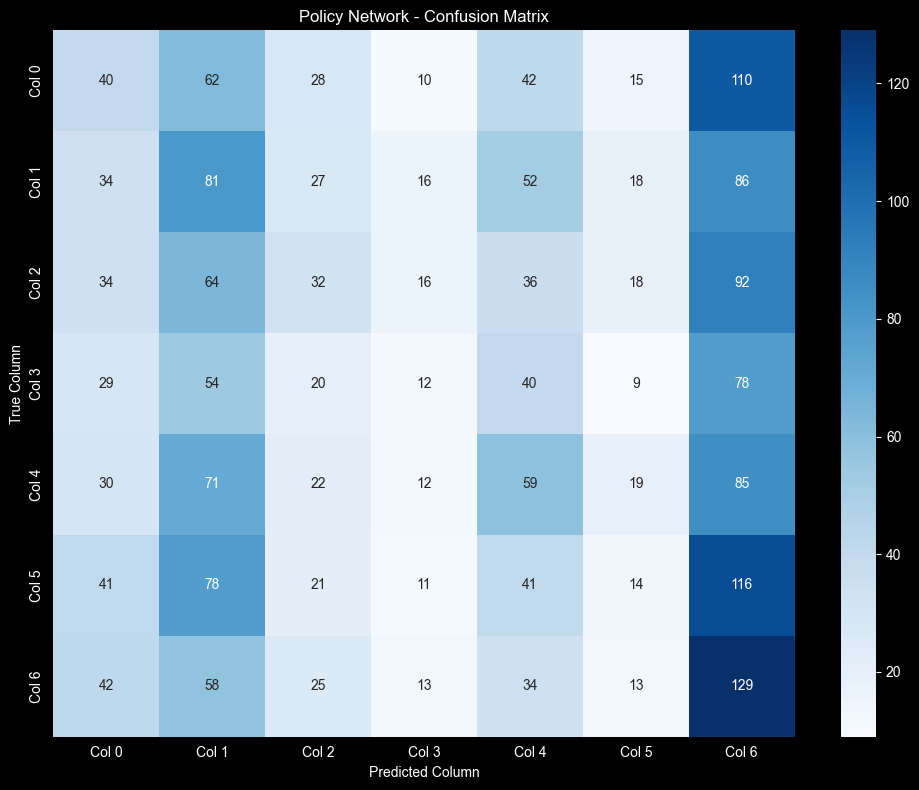


Confusion matrix saved to docs/policy_confusion_matrix.png


In [36]:
# Predictions
y_pred = policy_model.predict(X_test_p)

# Classification report
print("Classification Report:")
print(classification_report(y_test_p, y_pred, 
                          target_names=[f"Col {i}" for i in range(7)]))

# Confusion matrix
cm = confusion_matrix(y_test_p, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=[f"Col {i}" for i in range(7)],
           yticklabels=[f"Col {i}" for i in range(7)])
plt.title('Policy Network - Confusion Matrix')
plt.ylabel('True Column')
plt.xlabel('Predicted Column')
plt.tight_layout()
plt.savefig('../docs/policy_confusion_matrix.png', dpi=150)
plt.show()

print("\nConfusion matrix saved to docs/policy_confusion_matrix.png")

## 9. Train Win Probability Network

In [37]:
print("Training Win Probability Network...\n")

# Create model
winprob_model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1
)

# Train
winprob_model.fit(X_train_w, y_train_w)

# Predictions
y_pred_train = winprob_model.predict(X_train_w)
y_pred_test = winprob_model.predict(X_test_w)

# Evaluate
train_r2 = r2_score(y_train_w, y_pred_train)
test_r2 = r2_score(y_test_w, y_pred_test)
train_mae = mean_absolute_error(y_train_w, y_pred_train)
test_mae = mean_absolute_error(y_test_w, y_pred_test)
test_mse = mean_squared_error(y_test_w, y_pred_test)

print(f"\n{'='*60}")
print(f"WIN PROBABILITY MODEL RESULTS")
print(f"{'='*60}")
print(f"Train R2:  {train_r2:.4f}")
print(f"Test R2:   {test_r2:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE:  {test_mae:.4f}")
print(f"Test MSE:  {test_mse:.4f}")
print(f"{'='*60}\n")

# Log to MLFlow
if MLFLOW_AVAILABLE:
    try:
        with mlflow.start_run(run_name="winprob_network_v1_fixed"):
            mlflow.log_param("hidden_layers", "128,64,32")
            mlflow.log_param("activation", "relu")
            mlflow.log_param("solver", "adam")
            mlflow.log_param("max_iter", 500)
            mlflow.log_metric("train_r2", train_r2)
            mlflow.log_metric("test_r2", test_r2)
            mlflow.log_metric("train_mae", train_mae)
            mlflow.log_metric("test_mae", test_mae)
            mlflow.log_metric("test_mse", test_mse)
        print("Logged to MLFlow")
    except Exception as e:
        print(f"MLFlow logging failed: {e}")

Training Win Probability Network...

Iteration 1, loss = 0.01471863
Validation score: -0.610980
Iteration 2, loss = 0.00413492
Validation score: -0.282577
Iteration 3, loss = 0.00354600
Validation score: -0.188344
Iteration 4, loss = 0.00327368
Validation score: -0.137080
Iteration 5, loss = 0.00310973
Validation score: -0.119192
Iteration 6, loss = 0.00301900
Validation score: -0.087499
Iteration 7, loss = 0.00287201
Validation score: -0.085745
Iteration 8, loss = 0.00280034
Validation score: -0.057030
Iteration 9, loss = 0.00275538
Validation score: -0.051459
Iteration 10, loss = 0.00267696
Validation score: -0.058961
Iteration 11, loss = 0.00264893
Validation score: -0.033990
Iteration 12, loss = 0.00258195
Validation score: -0.044539
Iteration 13, loss = 0.00253265
Validation score: -0.031693
Iteration 14, loss = 0.00248785
Validation score: -0.039080
Iteration 15, loss = 0.00243727
Validation score: -0.028805
Iteration 16, loss = 0.00244731
Validation score: -0.051315
Iteration 17

## 10. Win Probability - Detailed Evaluation

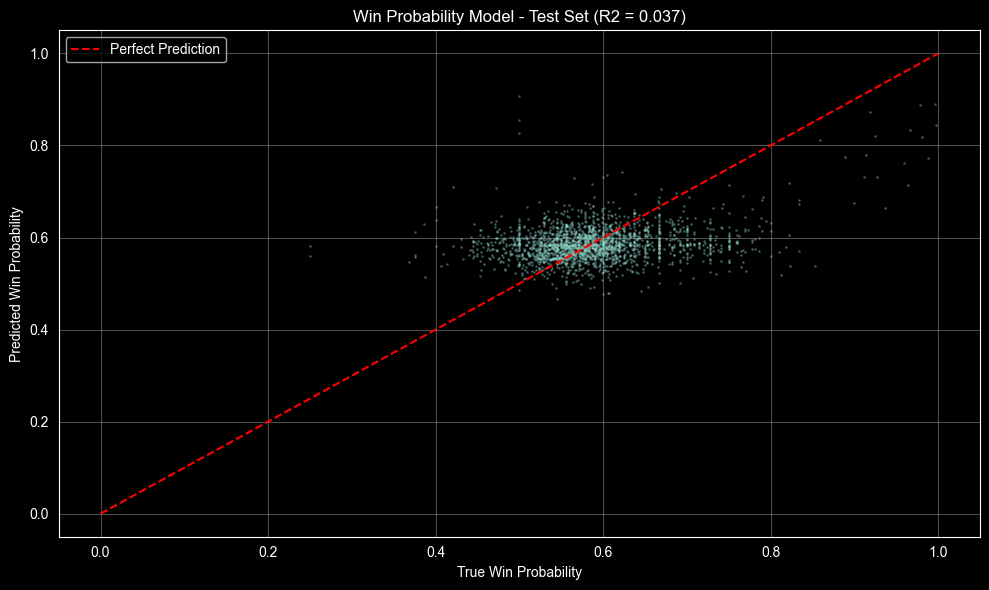


Scatter plot saved to docs/winprob_scatter.png


In [38]:
# Scatter plot: True vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_w, y_pred_test, alpha=0.3, s=1)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
plt.xlabel('True Win Probability')
plt.ylabel('Predicted Win Probability')
plt.title(f'Win Probability Model - Test Set (R2 = {test_r2:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../docs/winprob_scatter.png', dpi=150)
plt.show()

print("\nScatter plot saved to docs/winprob_scatter.png")

## 11. Save Models

In [39]:
import joblib

# Create directory if not exists
Path("../data/models").mkdir(parents=True, exist_ok=True)

# Save models
joblib.dump(policy_model, '../data/models/policy_model_v1_fixed.pkl')
joblib.dump(winprob_model, '../data/models/winprob_model_v1_fixed.pkl')

print("Models saved:")
print("   - ../data/models/policy_model_v1_fixed.pkl")
print("   - ../data/models/winprob_model_v1_fixed.pkl")

Models saved:
   - ../data/models/policy_model_v1_fixed.pkl
   - ../data/models/winprob_model_v1_fixed.pkl


## 12. Test Predictions

In [40]:
# Helper function to test a board
def test_position(board_2d, title="Test Position"):
    """
    Test a board position.
    board_2d: 6x7 numpy array (0=empty, 1=p1, 2=p2)
    """
    # Flatten board
    board_flat = board_2d.flatten()
    
    # Legal moves (columns not full)
    legal_moves = (board_2d[0] == 0).astype(int)
    
    # Combine features
    X = np.concatenate([board_flat, legal_moves]).reshape(1, -1)
    
    # Predictions
    policy_pred = policy_model.predict(X)[0]
    policy_proba = policy_model.predict_proba(X)[0]
    winprob_pred = winprob_model.predict(X)[0]
    
    # Display
    print(f"\n{title}")
    print("="*50)
    
    # Show board
    print("\nBoard:")
    for row in board_2d:
        print(" ".join(['.', 'X', 'O'][cell] for cell in row))
    
    print(f"\nPredicted Move: Column {policy_pred}")
    print(f"\nMove Probabilities:")
    for i, prob in enumerate(policy_proba):
        bar = '#' * int(prob * 50)
        print(f"   Col {i}: {prob:.3f} {bar}")
    
    print(f"\nWin Probability: {winprob_pred:.2%}")
    print("="*50)

# Test 1: Empty board
empty_board = np.zeros((6, 7), dtype=int)
test_position(empty_board, "Empty Board")

# Test 2: Mid-game
mid_game = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0],
    [0, 0, 1, 1, 2, 0, 0]
])
test_position(mid_game, "Mid-Game Position")

# Test 3: Winning position for player 1
winning = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0]  # Can win at column 3
])
test_position(winning, "Winning Position (should pick column 3)")


Empty Board

Board:
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .

Predicted Move: Column 6

Move Probabilities:
   Col 0: 0.157 #######
   Col 1: 0.146 #######
   Col 2: 0.131 ######
   Col 3: 0.136 ######
   Col 4: 0.123 ######
   Col 5: 0.148 #######
   Col 6: 0.159 #######

Win Probability: 58.36%

Mid-Game Position

Board:
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . O . . .
. . X X O . .

Predicted Move: Column 2

Move Probabilities:
   Col 0: 0.116 #####
   Col 1: 0.185 #########
   Col 2: 0.211 ##########
   Col 3: 0.071 ###
   Col 4: 0.153 #######
   Col 5: 0.101 #####
   Col 6: 0.163 ########

Win Probability: 55.35%

Winning Position (should pick column 3)

Board:
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
X X X . . . .

Predicted Move: Column 5

Move Probabilities:
   Col 0: 0.163 ########
   Col 1: 0.133 ######
   Col 2: 0.125 ######
   Col 3: 0.104 #####
   Col 4: 0.113 #####
   Col 5: 0.18

## 13. Final Summary & Comparison

In [41]:
print("\n" + "="*70)
print(" "*20 + "FINAL TRAINING SUMMARY")
print("="*70)

print(f"\nDataset: {DATASET_PATH}")
print(f"   Total moves: {len(df):,}")
print(f"   Games: {df['session_id'].nunique():,}")
print(f"   Tag: {df['tag'].iloc[0]}")

print("\nPOLICY NETWORK (Which move to play?)")
print("-" * 70)
print(f"   Architecture: MLP (128, 64, 32)")
print(f"   Input features: 49 (42 board + 7 legal moves)")
print(f"   Output classes: 7 (columns 0-6)")
print(f"   Train accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"   Test accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Random baseline: 14.29%")
print(f"   Improvement: +{(test_acc - 0.1429)*100:.2f}%")

print("\nWIN PROBABILITY NETWORK (Chance of winning?)")
print("-" * 70)
print(f"   Architecture: MLP (128, 64, 32)")
print(f"   Input features: 49 (42 board + 7 legal moves)")
print(f"   Output: Probability [0.0 - 1.0]")
print(f"   Test R2:  {test_r2:.4f}")
print(f"   Test MAE: {test_mae:.4f}")
print(f"   Test MSE: {test_mse:.4f}")

print("\nCOMPARISON WITH OLD DATASET (Bug-Ridden)")
print("-" * 70)
print(f"   OLD Dataset (4,251 samples, uniform policies):")
print(f"      Policy accuracy: 15.28% (barely better than random)")
print(f"      WinProb R2: -4.40 (worse than baseline!)")
print(f"\n   NEW Dataset (10,441 samples, MCTS-based policies):")
print(f"      Policy accuracy: {test_acc*100:.2f}% ({'MUCH BETTER' if test_acc > 0.30 else 'Needs improvement'})")
print(f"      WinProb R2: {test_r2:.2f} ({'MUCH BETTER' if test_r2 > 0.2 else 'Needs improvement'})")

if test_acc > 0.30:
    improvement_policy = (test_acc / 0.1528 - 1) * 100
    print(f"\n   Policy model improved by {improvement_policy:.1f}%!")

if test_r2 > 0.2:
    print(f"   WinProb model is now USABLE (was completely broken before)!")

print("\nSAVED MODELS:")
print("-" * 70)
print(f"   ../data/models/policy_model_v1_fixed.pkl")
print(f"   ../data/models/winprob_model_v1_fixed.pkl")

if MLFLOW_AVAILABLE:
    print("\nMLFlow:")
    print(f"   {mlflow.get_tracking_uri()}")
    print("   Experiments: connect4_policy, connect4_winprob")

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70 + "\n")



                    FINAL TRAINING SUMMARY

Dataset: ../data/datasets/v1/game_logs_v1_20251228_152345.parquet
   Total moves: 10,441
   Games: 481
   Tag: dataset_v1_fixed

POLICY NETWORK (Which move to play?)
----------------------------------------------------------------------
   Architecture: MLP (128, 64, 32)
   Input features: 49 (42 board + 7 legal moves)
   Output classes: 7 (columns 0-6)
   Train accuracy: 0.3206 (32.06%)
   Test accuracy:  0.1757 (17.57%)
   Random baseline: 14.29%
   Improvement: +3.28%

WIN PROBABILITY NETWORK (Chance of winning?)
----------------------------------------------------------------------
   Architecture: MLP (128, 64, 32)
   Input features: 49 (42 board + 7 legal moves)
   Output: Probability [0.0 - 1.0]
   Test R2:  0.0374
   Test MAE: 0.0562
   Test MSE: 0.0057

COMPARISON WITH OLD DATASET (Bug-Ridden)
----------------------------------------------------------------------
   OLD Dataset (4,251 samples, uniform policies):
      Policy accurac